In [169]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import h5py, json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
import pandas as pd
from target import build_tgt_matrix

%matplotlib inline

In [170]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [175]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/PSTH'

selected_sessions = [
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events: FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events: very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration - showcase for N2 
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, coma session with baseline AEPs
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, duration
# Old PPC sessions
'008229_hippoSIT_2022-05-17_21-44-43',  # chs: 0, 31
'008229_hippoSIT_2022-05-16_20-36-44',  # chs: 0, 56
'008229_hippoSIT_2022-05-20_15-54-39',  # chs: 0, 56
'008229_hippoSIT_2022-05-18_14-36-18',  # chs: 0, 56
]

session = selected_sessions[10]
channel = 0

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5name      = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, session)
if not os.path.exists(report_path):
    os.makedirs(report_path)

In [176]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
with h5py.File(aeps_file, 'r') as f:
    aeps = np.array(f['aeps_%s' % channel])
    aeps_events = np.array(f['aeps_events'])
    
# TODO find better way. Remove outliers
aeps[aeps > 5000]  = 5000
aeps[aeps < -5000] = -5000

# # load metrics
AEP_metrics_lims = {}
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_file, 'r') as f:
    for metric_name in f[str(channel)]['raw']:
        AEP_metrics_raw[metric_name]  = np.array(f[str(channel)]['raw'][metric_name])
        AEP_metrics_norm[metric_name] = np.array(f[str(channel)]['norm'][metric_name])
        AEP_metrics_lims[metric_name] = [int(x) for x in f[str(channel)]['raw'][metric_name].attrs['limits'].split(',')]

tgt_dur = cfg['experiment']['target_duration']
tgt_matrix = build_tgt_matrix(tl, aeps_events, tgt_dur)

aeps.shape, tgt_matrix.shape

((6120, 200), (65, 5))

## Overview

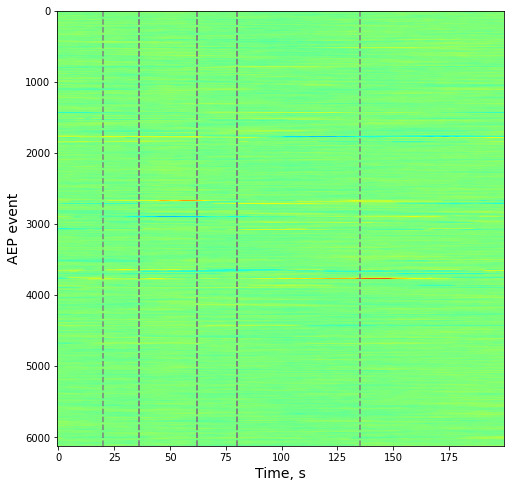

In [173]:
# AEPs profiles
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(aeps, aspect='auto', cmap='jet')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('AEP event', fontsize=14)
for key, value in AEP_metrics_lims.items():
    ax.axvline(value[0], color='gray', ls='--')
    ax.axvline(value[1], color='gray', ls='--')

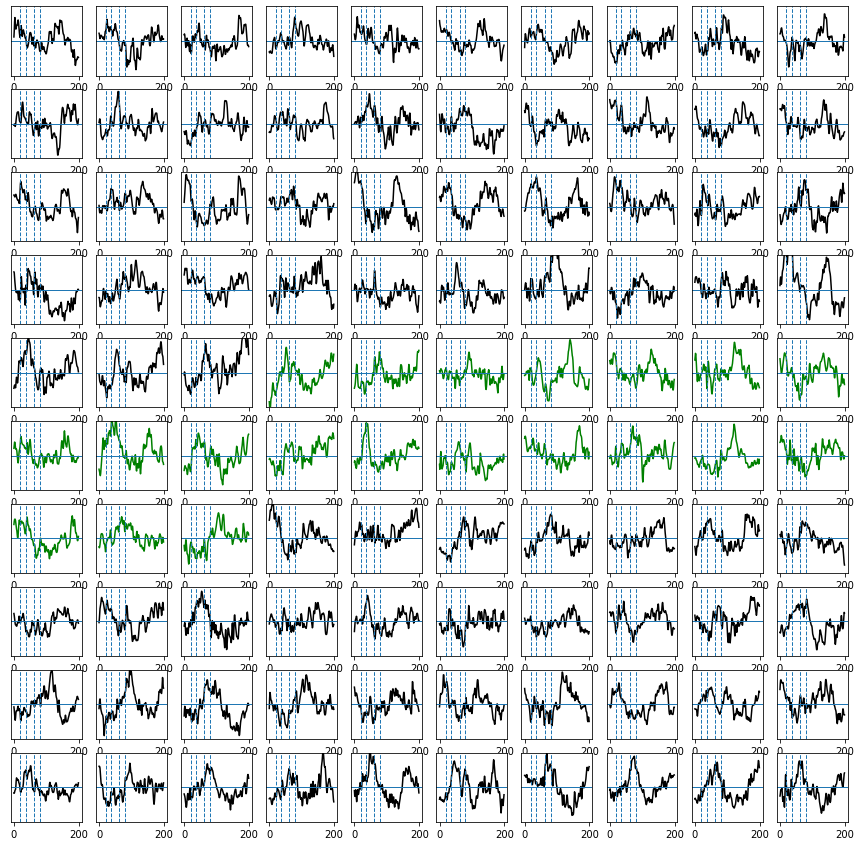

In [178]:
#look at 100 AEPs
fig = plt.figure(figsize=(15, 15))

#idx_l, idx_r = 1430, 1480
idx_l, idx_r = 1200, 1300
selected = aeps[idx_l:idx_r]
#selected = aeps[aeps_bgr_b_idxs + 1]

for i, aep in enumerate(selected):
    color = 'green' if aeps_events[idx_l + i][1] == 2 else 'black'
    
    ax = fig.add_subplot(10, 10, i+1)
    ax.plot(aep, color=color)
    ax.axhline(0, lw=1)
    for x_coord in [x[0] for x in AEP_metrics_lims.values()]:
        ax.axvline(x_coord, lw=1, ls='--')
    ax.set_ylim(-1500, 1500)
    ax.set_yticks([])

## AEP metrics relative BGR / TGT start

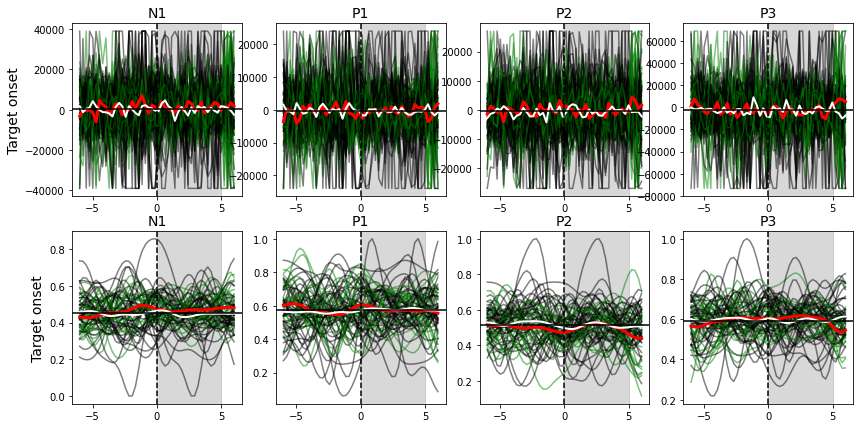

In [177]:
fig = plt.figure(figsize=(14, 7))

t_lag  = 6  # seconds
tgt_starts = []
labels = ['Target onset', 'Background onset']
dim = len(AEP_metrics_lims)
times = np.linspace(-6, 6, 48)

for i, metric_type in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for j, (m_name, metric) in enumerate(metric_type.items()):
        ax = fig.add_subplot(2, dim, i*dim + j + 1)
        means_succ = []
        means_miss = []

        for idx_aep, result in tgt_matrix[:, (2, 4)]:  # iterate over all tgt entrances / exits
            if idx_aep < 24 or idx_aep > len(aeps_events) - 24:
                continue
            clr = 'green' if result == 1 else 'black'
            ev_idxs = np.arange(idx_aep - 24, idx_aep + 24)  # +- 6 secs
            ax.plot(times, metric[ev_idxs], color=clr, alpha=0.5)
            if result == 1:
                means_succ.append(metric[ev_idxs])
            else:
                means_miss.append(metric[ev_idxs])

        # plot means
        ax.plot(times, np.array(means_succ).mean(axis=0), color='red', lw=3)
        ax.plot(times, np.array(means_miss).mean(axis=0), color='white', lw=2)
        ax.axvline(0, ls='--', color='black')
        ax.axhline(metric.mean(), color='black')
        ax.set_title(m_name, fontsize=14)
        ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
        if j == 0:
            ax.set_ylabel(labels[j], fontsize=14)
            
#fig.tight_layout()
#fig.savefig(os.path.join(report_path, 'AEP_metrics_tgt_onset.pdf'))

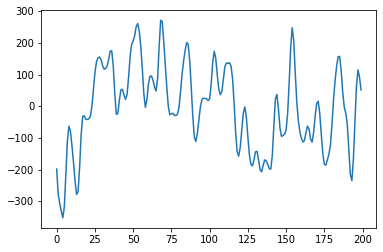

In [100]:
tgt_succ = tgt_matrix[tgt_matrix[:, 4] == 1]
plt.plot(aeps[tgt_succ[:, 2][:-2] + 20].mean(axis=0))

## AEPs timeline

In [143]:
unit_id = '6-6'

with h5py.File(h5name, 'r') as f:
    i_rate = np.array(f['units'][str(unit_id)]['inst_rate'])
    s_times = np.array(f['units'][str(unit_id)]['spike_times'])

(150.0, 225.0)

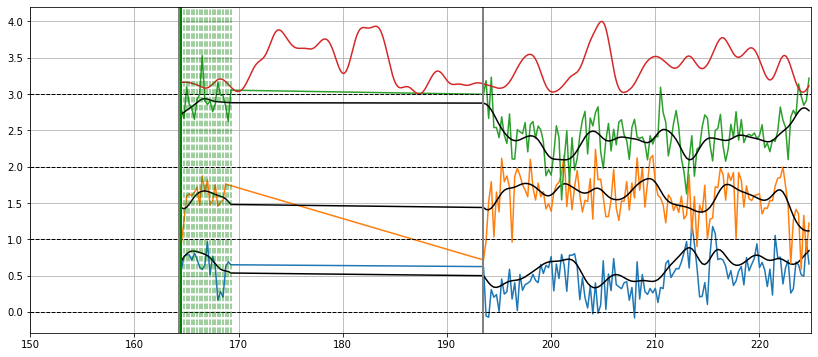

In [144]:
t_start, t_end = 150, 225  # secs

fig = plt.figure(figsize=(14, 6))

# mins in the N1 range
ax = fig.add_subplot(1, 1, 1)
ev_idxs  = np.where((aeps_events[:, 0] > t_start) & (aeps_events[:, 0] < t_end))[0]

normed   = [N1_norm, P1_norm, N2_norm]
smoothed = [N1_smooth_norm, P1_smooth_norm, N2_smooth_norm]
ratios   = [N1_ratio, P1_ratio, N2_ratio]

for i in range(3):  # AEP N1, P1, N2 metrics
    norm = normed[i]
    vals = ratios[i] * (norm[ev_idxs] - norm[ev_idxs].mean()) + norm[ev_idxs].mean()
    ax.plot(aeps_events[ev_idxs][:, 0], i + vals)
    ax.plot(aeps_events[ev_idxs][:, 0], i + smoothed[i][ev_idxs], color='black')
    #ax.axhline(i + smoothed[i].mean(), lw=1, ls='--', color='black')
    ax.axhline(i, lw=1, ls='--', color='black')

# selected unit firing rate
idxs_tl = np.where((tl[:, 0] > aeps_events[ev_idxs[0]][0]) & (tl[:, 0] < aeps_events[ev_idxs[-1]][0]))[0]
ax.plot(tl[idxs_tl][:, 0], 3 + to_normed(i_rate[idxs_tl]))
ax.grid()
ax.axhline(3, lw=1, ls='--', color='black')

sel_events = aeps_events[ev_idxs]
tgt_events = sel_events[sel_events[:, 1] == 2]
for t_event in tgt_events[:, 0]:
    ax.axvline(t_event, color='green', ls='--', alpha=0.5)
for t_event in tl[idxs_tgt_start][:, 0]:
    ax.axvline(t_event, color='green', lw=2)
for t_event in tl[idxs_bgr_start][:, 0]:
    ax.axvline(t_event, color='gray', lw=2)  
ax.set_xlim(t_start, t_end)